## Построение дерева решений для прогноза сердечно-сосудистых заболеваний

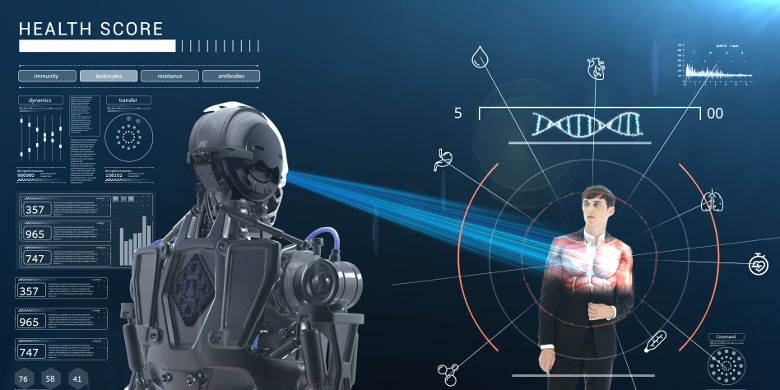

In [1]:
from PIL import Image
img = Image.open('C:\ProgramData\Anaconda3\Scripts\ML\Open Data Science\ИИС\сс.png')
img

### Импортируем необходимые нам библиотеки:

**NumPy** — это расширение языка Python, добавляющее поддержку больших многомерных массивов и матриц, вместе с большой библиотекой высокоуровневых математических функций для операций с этими массивами.

** Pandas **- библиотека для обработки и анализа данных. Pandas предоставляет специальные структуры данных и операции для манипулирования числовыми таблицами и временными рядами.

** pyplot ** - питоновская библиотека для создания двухмерных графиков высокого качества.

**train_test_split** - split arrays or matrices into random train and test subsets.

**GridSearchCV** - exhaustive search over specified parameter values for an estimator.

** StratifiedKFold ** - Stratified K-Folds cross-validator. This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

**accuracy_score** - accuracy classification score.
In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

** DecisionTreeClassifier ** - а decision tree classifier.

** export_graphviz ** - export a decision tree in DOT format.

** RandomForestClassifier ** - a random forest classifier.
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

**Основные параметры класса sklearn.tree.DecisionTreeClassifier:**

- **max_depth** – максимальная глубина дерева
- **max_features** — максимальное число признаков, по которым ищется лучшее разбиение в дереве (это нужно потому, что при большом количестве признаков будет "дорого" искать лучшее (по критерию типа прироста информации) разбиение среди всех признаков)
- **min_samples_leaf** – минимальное число объектов в листе. У этого параметра есть понятная интерпретация: скажем, если он равен 5, то дерево будет порождать только те классифицирующие правила, которые верны как минимум для 5 объектов

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

**Описание данных.**

*Объективные признаки:*

 - Возраст (age)
 - Рост (height)
 - Вес (weight)
 - Пол (gender) 1 - женщины, 2-мужчины
 

*Результаты измерения:*

 - Артериальное давление верхнее и нижнее (ap_hi, ap_lo)
 - Холестерин (cholesterol)
 - Глюкоза (gluc)
 

*Субъективные признаки (со слов пациентов):*

 - Курение (smoke)
 - Употребление алкоголя (alco)
 - Физическая активность (active)
 
*Целевой признак (который интересно будет прогнозировать):*
 - Наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра (cardio)

Значения показателей холестерина и глюкозы представлены одним из трех классов: 1-норма, 2-выше нормы, 3-значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра. 

Загружаем данные.

In [4]:
df = pd.read_csv('mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [5]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
print('Размер датасета: ', df.shape)

Размер датасета:  (70000, 12)


In [7]:
df['age'] = df['age'] //365 

In [8]:
df = df.rename(columns={'age': 'возраст', 'gender': 'пол', 'height': 'рост', 
                       'weight': 'вес', 'ap_hi': 'верх артер давлен', 'ap_lo': 'нижн артер давлен',
                       'cholesterol': 'холестерин', 'gluc': 'глюкоза', 'smoke': 'курение',
                       'alco': 'алкоголь', 'active': 'активность', 'cardio': 'наличие заболев'})

In [9]:
df.head()

,возраст,пол,рост,вес,верх артер давлен,нижн артер давлен,холестерин,глюкоза,курение,алкоголь,активность,наличие заболев
id,,,,,,,,,,,,
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


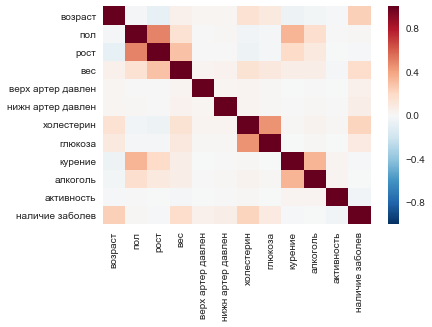

In [10]:
sns.heatmap(df.corr()); 

Делим на тренировочную и тестовую выборку.

In [11]:
df.keys()

Index(['возраст', 'пол', 'рост', 'вес', 'верх артер давлен',
       'нижн артер давлен', 'холестерин', 'глюкоза', 'курение', 'алкоголь',
       'активность', 'наличие заболев'],
      dtype='object')

In [12]:
x = ['возраст', 'пол', 'рост', 'вес', 'верх артер давлен','нижн артер давлен', 'холестерин', 'глюкоза', 'курение', 'алкоголь',
       'активность']

X_train, X_valid, y_train, y_valid = train_test_split(df[x], df['наличие заболев'], random_state = 17, test_size = 0.3)

In [13]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)

tree_fit = tree.fit(X_train, y_train)

print('Score: ', tree_fit.score(X_train, y_train))

Score:  0.727714285714


In [14]:
export_graphviz(tree, feature_names=x, out_file='tree1.dot')

#Пользуйся http://www.webgraphviz.com

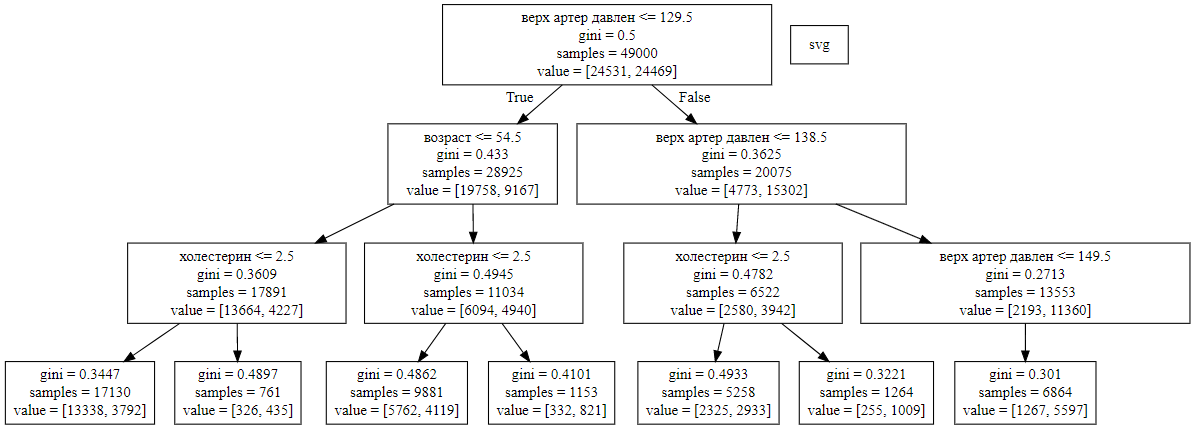

In [15]:
from PIL import Image
img = Image.open('tree1.png')
img

C помощью обученного дерева сделаем прогноз для отложенной выборки (X_valid, y_valid). Посчитаем долю верных ответов (accuracy).

In [16]:
y_pred = tree_fit.predict(X_valid)
print('accuracy_score: ', accuracy_score(y_valid, y_pred))

accuracy_score:  0.721285714286


In [17]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)
tree_params

{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

In [18]:
%%time
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Wall time: 21 s


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   20.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [19]:
print("Best params:", tree_grid.best_params_)
print("Best cross validaton score", tree_grid.best_score_)

Best params: {'max_depth': 6}
Best cross validaton score 0.732183673469


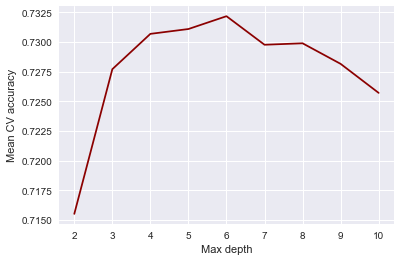

In [20]:
plt.plot(tree_params['max_depth'], 
         tree_grid.cv_results_['mean_test_score'], color='darkred')
plt.xlabel('Max depth')
plt.ylabel('Mean CV accuracy');

In [21]:
tree = DecisionTreeClassifier(max_depth=6, random_state=17)

tree_fit = tree.fit(X_train, y_train)

print('Score: ', tree_fit.score(X_train, y_train))

Score:  0.735530612245


In [22]:
y_pred = tree_fit.predict(X_valid)
print('accuracy_score: ', accuracy_score(y_valid, y_pred))

accuracy_score:  0.725857142857


### Случайный лес sklearn, подбор гиперпараметров

In [23]:
max_depth_values = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
max_features_values = [4, 5, 6, 7]
forest_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [24]:
rf = RandomForestClassifier(random_state=17) 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
random_grid = GridSearchCV(rf, forest_params, cv=skf, scoring = 'roc_auc')

In [25]:
random_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=17,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'max_features': [4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [26]:
print("Best params:", random_grid.best_params_)
print("Best cross validaton score", random_grid.best_score_)

Best params: {'max_depth': 8, 'max_features': 5}
Best cross validaton score 0.800929629455


In [27]:
rf = RandomForestClassifier(max_depth=8, max_features=5, random_state=17)

rf_fit = rf.fit(X_train, y_train)

print('Score: ', rf_fit.score(X_train, y_train))

Score:  0.744367346939


In [28]:
y_pred = rf_fit.predict(X_valid)
print('accuracy_score: ', accuracy_score(y_valid, y_pred))

accuracy_score:  0.731666666667


## Проверка данных, получение результатов

In [29]:
df2 = df.drop('наличие заболев', axis=1)
df2.head()

,возраст,пол,рост,вес,верх артер давлен,нижн артер давлен,холестерин,глюкоза,курение,алкоголь,активность
id,,,,,,,,,,,
0,50,2,168,62.0,110,80,1,1,0,0,1
1,55,1,156,85.0,140,90,3,1,0,0,1
2,51,1,165,64.0,130,70,3,1,0,0,0
3,48,2,169,82.0,150,100,1,1,0,0,1
4,47,1,156,56.0,100,60,1,1,0,0,0


## 1. John

In [30]:
John = np.array([[49, 2, 170, 80.0, 140, 80, 2, 2, 0, 0, 1]])
new = pd.DataFrame(John, columns = df2.columns)
new

,возраст,пол,рост,вес,верх артер давлен,нижн артер давлен,холестерин,глюкоза,курение,алкоголь,активность
0,49.0,2.0,170.0,80.0,140.0,80.0,2.0,2.0,0.0,0.0,1.0


In [31]:
New_cardio = rf.predict(John) 

cardio = int(New_cardio[0]) 
print('Cardio of the John : ', cardio)

Cardio of the John :  1


## 2. Ola

In [32]:
Ola = np.array([[40, 1, 165, 56.0, 100, 60, 1, 1, 0, 0, 1]])
new = pd.DataFrame(Ola, columns = df2.columns)
new

,возраст,пол,рост,вес,верх артер давлен,нижн артер давлен,холестерин,глюкоза,курение,алкоголь,активность
0,40.0,1.0,165.0,56.0,100.0,60.0,1.0,1.0,0.0,0.0,1.0


In [33]:
New_cardio = rf.predict(Ola) 

cardio = int(New_cardio[0]) 
print('Cardio of the Ola : ', cardio)

Cardio of the Ola :  0


## 3. Misha

In [34]:
Misha = np.array([[63, 2, 170, 85.0, 150, 80, 3, 1, 1, 0, 0]])
new = pd.DataFrame(Misha, columns = df2.columns)
new

,возраст,пол,рост,вес,верх артер давлен,нижн артер давлен,холестерин,глюкоза,курение,алкоголь,активность
0,63.0,2.0,170.0,85.0,150.0,80.0,3.0,1.0,1.0,0.0,0.0


In [35]:
New_cardio = rf.predict(Misha) 

cardio = int(New_cardio[0]) 
print('Cardio of the Misha: ', cardio)

Cardio of the Misha:  1
